# 11. Ajuste avanzado modelo Random Forest clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE).
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No     |
| :-------                  | :------:    |
| Escalado de datos         | No          |
| Ajuste de hiperparametros | Si          |
| Sobremuestreo             | Si          |
| Ajuste de pesos de clase  | No          |
| Incluye variable ciclo    | No          |


### Cargar librerias

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import pandas_profiling
np.random.seed(9999) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

# sobremuestreo
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot
from pprint import pprint
from sklearn.metrics import fbeta_score
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


### Funciones

In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla potencial"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla Potencial"})
    cm.fit(data_train, label_train)
    cm.score(data_test, label_test)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# ruta para grabar medidas de desempeño
ruta4a = "D:/alexh/Documents/Maestria en estadistica/proyecto de grado/cuadernos proyecto/Nasa Turbo Fan/Modelos 4a.xlsx"
writer = pd.ExcelWriter(ruta4a, engine='openpyxl')

### Preparar datos agil

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train['clase2']=train['clase1']
train.loc[train['ttf']<=15, 'clase2'] =2
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test['clase2']=test['clase1']
test.loc[test['ttf']<=15, 'clase2'] =2
data_train=train.iloc[:,np.r_[2:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[2:26]]
label_test=test.iloc[:,27]
label_train2=train.iloc[:,28]
label_test2=test.iloc[:,28]

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

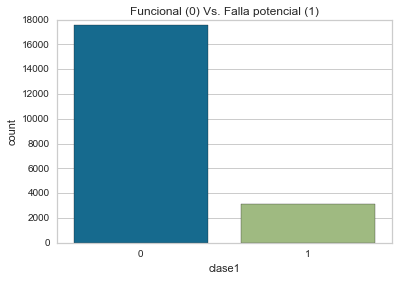

In [5]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [6]:
# sobremuestreo de minorías sintéticas (SMOTE)

data_traino, label_traino = SMOTE().fit_resample(data_train, label_train)
print(sorted(Counter(label_traino).items()))

[(0, 17531), (1, 17531)]


In [7]:
label_train=pd.Series(label_traino)

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

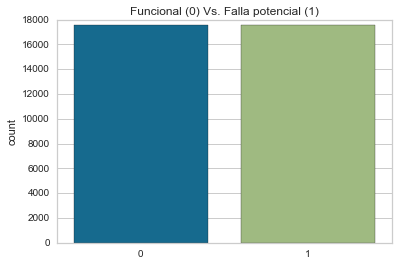

In [8]:
# grafica de base de entrenamiento equilibrada
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [9]:
data_train= pd.DataFrame(data_traino, columns=data_train.columns)

In [10]:
print("numero de dimensiones =", data_train.ndim)
print("tamaño de la tabla =", data_train.shape)
print("total datos =", data_train.size)

numero de dimensiones = 2
tamaño de la tabla = (35062, 24)
total datos = 841488


In [11]:
print("numero de dimensiones =", label_train.ndim)
print("tamaño de la tabla =", label_train.shape)
print("total datos =", label_train.size)

numero de dimensiones = 1
tamaño de la tabla = (35062,)
total datos = 35062


In [12]:
data_train.head()

,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


## Modelos de clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE)

## Random Forest Classifier hiperparametros por defecto

In [71]:
modelo1=RandomForestClassifier(random_state=1, n_estimators=10)
modelo1.fit(data_train, label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [67]:
# lista de hiperparametros por defecto del modelo
print('lista de hiperparametros por defecto del modelo\n')
pprint(modelo1.get_params())

lista de hiperparametros por defecto del modelo

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [68]:
label_pred1 = modelo1.predict(data_test)

In [69]:
# para evaluar cuales caracteristicas tiene mayor peso en el modelo
fi=modelo1.feature_importances_
fi

array([7.91661768e-03, 8.81578227e-03, 0.00000000e+00, 0.00000000e+00,
       3.28102951e-02, 6.10171495e-02, 1.49178853e-01, 0.00000000e+00,
       1.71136663e-05, 2.00798953e-02, 5.19351430e-02, 3.57408999e-02,
       0.00000000e+00, 1.80509182e-01, 1.03346063e-01, 1.44951705e-02,
       3.75264434e-02, 1.48679704e-01, 0.00000000e+00, 3.35051218e-02,
       0.00000000e+00, 0.00000000e+00, 7.81607306e-02, 3.62658361e-02])

#### Evaluacion del modelo



MATRIZ DE CONFUSION




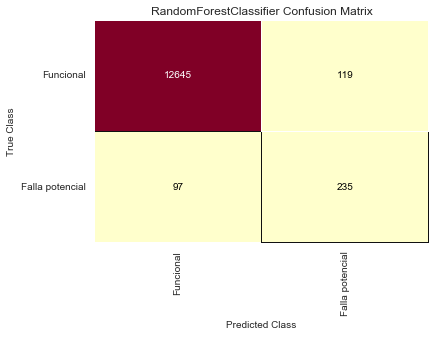



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9835064141722664
ROC AUC: 0.8492541145465597
------------------------------------------------------------
Precisión por clase: [0.99238738 0.66384181]
Sensibilidad - Recall por clase: [0.9906769  0.70783133]
F1 por clase: [0.9915314 0.6851312]
------------------------------------------------------------
F1 Macro: 0.8383312998553589
F1 Micro: 0.9835064141722664
F1 Weighted: 0.9837637753741172
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8492541145465597
Sensibilidad - Recall Micro: 0.9835064141722664
Sensibilidad - Recall Weighted: 0.9835064141722664
------------------------------------------------------------
Precisión Macro: 0.8281145941133331
Precisión Micro: 0.9835064141722664
Precisión Weighted: 0.9840583386219428
------------------------------------------------------------
Verdaderos positivos - True Positives: 235
Verdaderos negativos - True Negatives: 12645
Falsos positivos

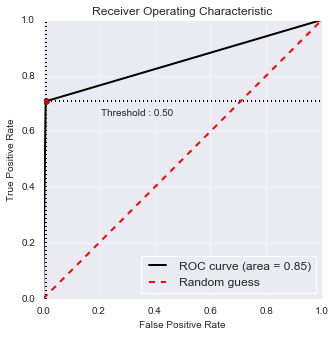

In [72]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1, label_pred1)

## Busqueda en cuadricula aleatoria de hiperparametros con validacion cruzada

In [34]:
# Number of trees in random forest
n_estimators = [10, 300, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 10, 12] 
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

# tomado de https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

{'bootstrap': [True, False],
 'max_depth': [2, 10, 12],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 10],
 'n_estimators': [10, 300, 1000]}


In [42]:
# Use la cuadrícula aleatoria para buscar los mejores hiperparámetros
rf = RandomForestClassifier()
# Búsqueda aleatoria de parámetros, usando validación cruzada cv=3, 
# busque en 10 combinaciones diferentes y use todos los procesadores disponibles
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=0, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(data_train, label_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [43]:
# mejores hiperparametros
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 12,
 'bootstrap': False}

In [45]:
print(rf_random.best_score_)

0.9674006046432034


In [46]:
modelo1a= rf_random.best_estimator_
modelo1a.fit(data_train, label_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
label_pred1a = modelo1a.predict(data_test)



MATRIZ DE CONFUSION




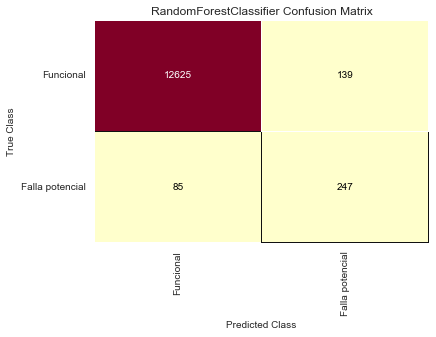



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.982895540623091
ROC AUC: 0.8665429502403219
------------------------------------------------------------
Precisión por clase: [0.99331235 0.63989637]
Sensibilidad - Recall por clase: [0.98911   0.7439759]
F1 por clase: [0.99120672 0.68802228]
------------------------------------------------------------
F1 Macro: 0.8396145023502034
F1 Micro: 0.982895540623091
F1 Weighted: 0.9835206154386295
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.866542950240322
Sensibilidad - Recall Micro: 0.982895540623091
Sensibilidad - Recall Weighted: 0.982895540623091
------------------------------------------------------------
Precisión Macro: 0.8166043627676791
Precisión Micro: 0.982895540623091
Precisión Weighted: 0.9843528148204607
------------------------------------------------------------
Verdaderos positivos - True Positives: 247
Verdaderos negativos - True Negatives: 12625
Falsos positivos - Fal

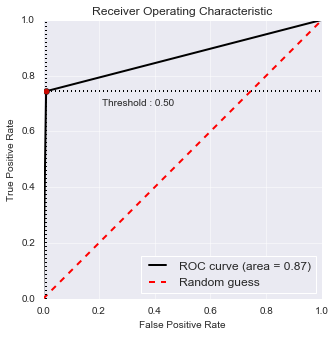

In [48]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1a, label_pred1a)

## Grid Search with Cross Validation

In [59]:

model = RandomForestClassifier(random_state=0)
parameters= {'n_estimators': [500, 800, 1000, 1200, 2000,],
            'max_features': ['auto'],
            'criterion': ['entropy', 'gini'],
            'max_depth': [ 8, 12, 15],
            'bootstrap': [True],
            'min_samples_split': [2, 4, 6],
            'min_samples_leaf': [3, 4, 5],
            }                                       

acc_scorer=make_scorer(fbeta_score, beta=1)

grid = GridSearchCV(estimator = model, param_grid=parameters, cv=3, verbose=2, scoring=acc_scorer, n_jobs = -1)

%time grid.fit(data_train, label_train)


Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 69.5min finished


Wall time: 1h 9min 53s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 

In [60]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}
0.968457138482897
90


In [61]:
modelo2a= grid.best_estimator_
modelo2a.fit(data_train, label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [62]:
label_pred2a = modelo2a.predict(data_test)

In [63]:
# para evaluar cuales caracteristicas tiene mayor peso en el modelo
fi=modelo2a.feature_importances_
fi

array([6.81321752e-03, 8.08235911e-03, 0.00000000e+00, 0.00000000e+00,
       4.07433629e-02, 3.05777526e-02, 1.12574577e-01, 0.00000000e+00,
       6.88506089e-05, 8.66664812e-02, 2.08896795e-02, 4.26831606e-02,
       0.00000000e+00, 1.75324900e-01, 1.18629483e-01, 1.99290631e-02,
       4.02880802e-02, 6.96553670e-02, 0.00000000e+00, 1.03315030e-01,
       0.00000000e+00, 0.00000000e+00, 5.56293537e-02, 6.81292818e-02])



MATRIZ DE CONFUSION




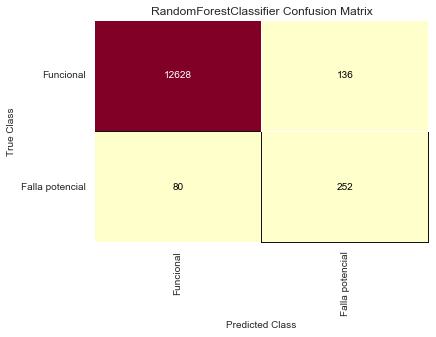



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9835064141722664
ROC AUC: 0.8741905887416795
------------------------------------------------------------
Precisión por clase: [0.99370475 0.64948454]
Sensibilidad - Recall por clase: [0.98934503 0.75903614]
F1 por clase: [0.9915201 0.7      ]
------------------------------------------------------------
F1 Macro: 0.8457600502512563
F1 Micro: 0.9835064141722664
F1 Weighted: 0.984129700886841
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8741905887416793
Sensibilidad - Recall Micro: 0.9835064141722664
Sensibilidad - Recall Weighted: 0.9835064141722664
------------------------------------------------------------
Precisión Macro: 0.821594644497013
Precisión Micro: 0.9835064141722664
Precisión Weighted: 0.9849783393511322
------------------------------------------------------------
Verdaderos positivos - True Positives: 252
Verdaderos negativos - True Negatives: 12628
Falsos positivos -

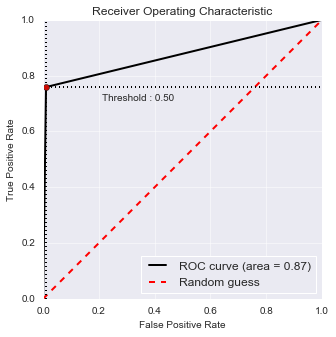

In [65]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo2a, label_pred2a)

Con el ajuste de Hiperparametros de obtiene una mejora en el Recall de 2 puntos porcentuales